# Update Risk Premia Strategy Positions

Running this notebook calculates current weights for the Risk Premia portfolio and places orders with Interactive Brokers to update the current portfolio accordingly. 

The intent to manually run the notebook at a regular rebalance frequency (monthly).

The notebook consists of two parts:

1. Calculating target portfolio weights using data obtained from Alpha Vantage. You'll need your own Alpha Vantage key to run this part of the notebook. 
2. Calculating position deltas between the existing portfolio and the target portfolio, and then placing orders to achieve the target portfolio. 

If you are unable to access data from Alpha Vantage to calculate weights, you can enter them manually as the `deltas_dict` object in the section titled "Prepare position deltas and contract objects" below. Example code: 

`deltas_dict = {'EFA': 3, 'GBTC': 0, 'IEF': -1, 'TLT': 0, 'VTI': -1}`


## Import required modules

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm
import datetime

from alpha_vantage.timeseries import TimeSeries
from time import sleep
from tiingo import TiingoClient
from ib_insync import *

from IPython.display import Image
from IPython.core.display import HTML 

%matplotlib inline
fig_size = (10, 6)
plt.rcParams["figure.figsize"] = fig_size
%config InlineBackend.figure_format = 'retina'

## Calculate Current Portfolio Weights

### Define functions for calculating weights

In [2]:
def get_srp_weights(returns, vol_lookback):
    """
    returns current srp werights given a pandas DataFrame of returns and a vol_lookback period
    """
    n_assets = len(returns.columns)
    vols = returns.iloc[-vol_lookback:, :].apply(lambda x: np.std(x)*np.sqrt(252), axis=0)
    raw_weights = 1/vols
    weights = raw_weights/np.sum(raw_weights)
    
    return weights

def get_cor_adjustments(returns, corr_lookback):
    """
    returns current correlation adjustments given a pandas DataFrame of returns and a corr_lookback period
    """
    cor = returns.iloc[-corr_lookback:, :].corr()
    pairwise_ave_cor = cor.mean(axis=1)
    zscore_pairwise_ave_cor = (pairwise_ave_cor - pairwise_ave_cor.mean())/pairwise_ave_cor.std()
    gauss_scale = 1 - norm.cdf(zscore_pairwise_ave_cor, 0, 1)
    raw_adjustments = gauss_scale/gauss_scale.sum()
    norm_adjustments = raw_adjustments - 1./len(returns.columns)
    
    return norm_adjustments

def adjust_weights(vol_weights, corr_adjustments, shrinkage):
    raw_weights = vol_weights * (1 +corr_adjustments * shrinkage)
    adj_weights = raw_weights/raw_weights.sum()
    
    return adj_weights

def get_momo_adjustments(returns, formation_period):
    """
    returns current cross-sectional zscore of total return momentum 
    given a pandas DataFrame of returns and formation_period
    """
    synth_prices = (returns+1).cumprod()
    roc = (synth_prices.iloc[-1,:]/synth_prices.iloc[-formation_period-1,:]-1)
    momo_adjustments = (roc - roc.mean())/roc.std()
    
    return momo_adjustments

def get_sma_slope_adjustments(returns, formation_period):
    """
    returns current cross-sectional zscore of slope of moving average 
    given a pandes DataFrame of returns and a formation_period
    """
    synth_prices = (returns+1).cumprod()
    sma = synth_prices.iloc[-formation_period-1:,:].rolling(formation_period).mean()
    sma_slope = (sma.iloc[-1,:]/sma.iloc[-2,:])-1
    momo_adjustments = (sma_slope - sma_slope.mean())/sma_slope.std()
    
    return momo_adjustments

def adjust_momo_weights(base_weights, momo_adjustments, z_score_cutoff, multiplier):
    raw_weights = base_weights * (1 + ((momo_adjustments >= z_score_cutoff) * multiplier))
    adj_weights = raw_weights/raw_weights.sum()
    
    return adj_weights

def get_momo_adjusted_weights(returns, base_weights, formation_periods, z_score_cutoff, multiplier):
    """
    returns current momentum-adjusted weights given a pandes DataFrame of returns and a formation_period
    """
    momo_weights = base_weights

    for period in formation_periods :
        momo_adjustments = get_momo_adjustments(returns, period)
        momo_weights = adjust_momo_weights(momo_weights, momo_adjustments, z_score_cutoff, multiplier)

    for period in formation_periods :
        momo_adjustments = get_sma_slope_adjustments(returns, period)
        momo_weights = adjust_momo_weights(momo_weights, momo_adjustments, z_score_cutoff, multiplier)

    return momo_weights

def cap_allocation_and_rescale(weights, ticker, cap=0.15):
    """
    cap the allocation into ticker and rescale remaining weights
    """
    if weights[ticker] > cap:
        weights = (1-cap)*weights.drop(ticker)/weights.drop(ticker).sum()
        weights[ticker] = cap
    
    return weights

def split_allocation(weights, ticker, split_ticker, ratio=0.5):
    """
    split the allocation into ticker into ticker and split_ticker according to ratio
    """
    weights[split_ticker] = (1-ratio)*weights[ticker]
    weights[ticker] = ratio*weights[ticker]
    
    global tradeable_universe
    if split_ticker not in tradeable_universe:
        tradeable_universe.append(split_ticker)
    
    return weights   

### Create universe of assets

* In our case, we are including crytpo exposure in our portfolio
* Currently, our crypto assets are held with a different broker, so we don't trade them here
* We use GBTC as a proxy for our crypto exposure in order to consider it when calculating portfolio weights
* That is, we consider them here, but in the trading part of the notebook

In [3]:
# create universe
universe = sorted(["VTI", "UST", "TLT", "GBTC", "VEA", "VWO", "EMB", "VNQI"])

tradeable_universe = universe.copy()  
tradeable_universe.remove("GBTC")  # GBTC exposure held elsewhere

### Get and plot returns data for all assets
_Choose either Alphavantage or Tiingo to get data from and execute the respective cell below. 
There is no need to run both cells._

#### Use Alphavantage
* Acquire daily data from Alpha Vantage. 
* You can either do 
```python
TimeSeries(key='YOUR_ALPHAVANTAGE_KEY', output_format='pandas')
``` 
**or** place `'YOUR_ALPHAVANTAGE_KEY'` in your `PATH` variables, and simply do 
```python
TimeSeries(output_format='pandas')
``` 
as I've done here. 

In [4]:
# from an external source - AV
ts = TimeSeries(output_format="pandas")

5 assets loaded. waiting 60 seconds per AV api frequency limitations


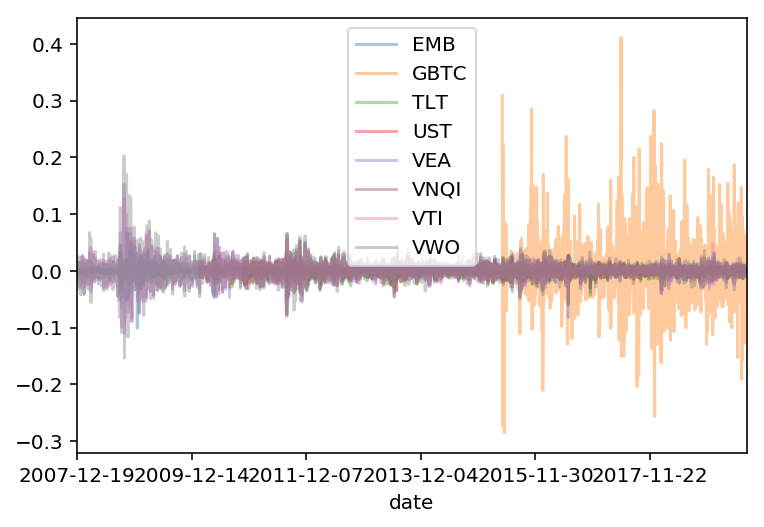

In [5]:
prices = pd.DataFrame()
for idx, s in enumerate(universe):
    if idx and idx % 5 == 0:
        print("5 assets loaded. waiting 60 seconds per AV api frequency limitations")
        sleep(60)
    data, meta_data = ts.get_daily_adjusted(s, outputsize='full')
    prices[s] = data['5. adjusted close']
    
returns = prices.pct_change()   
returns.plot(alpha=0.4);

# prices.to_csv("path/filename")

In [6]:
def get_cor_adjustments(returns, corr_lookback):
    """
    returns current correlation adjustments given a pandas DataFrame of returns and a corr_lookback period
    """
    cor = returns.iloc[-corr_lookback:, :].corr()
    pairwise_ave_cor = cor.mean(axis=1)
    zscore_pairwise_ave_cor = (pairwise_ave_cor - pairwise_ave_cor.mean())/pairwise_ave_cor.std()
    gauss_scale = 1 - norm.cdf(zscore_pairwise_ave_cor, 0, 1)
    raw_adjustments = gauss_scale/gauss_scale.sum()
    norm_adjustments = raw_adjustments - 1./len(returns.columns)
    
    return norm_adjustments

#### Use Tiingo
* Acquire daily data from Tiingo if you prefer over Alpha Vantage. 
* You can either do:

 ```python
 config = {}
 config['api_key'] = "YOUR_TIINGO_KEY"
 client = TiingoClient(config)
    ``` 
 
 **or** place `'YOUR_TIINGO_KEY'` in your `PATH` variables, and simply do 
 ```python 
 client = TiingoClient()
 ``` 
 as I've done here. 

In [9]:
# from an external source - Tiingo
# config = {}
# config['session'] = True
# client = TiingoClient(config)

In [10]:
# prices = pd.DataFrame()
# for s in universe:
#     prices[s] = client.get_dataframe(s, metric_name='adjClose', startDate = "1900-01-01")


# returns = prices.pct_change()   
# returns.plot();

### Calculate portfolio weights

In [11]:
vol_lookback = 90
corr_lookback = 120
formation_periods = np.array([3, 6, 9, 12])*22
z_score_cutoff = 0
momo_multiplier = 0.1

vol_weights = get_srp_weights(returns, vol_lookback)
cor_adjust = get_cor_adjustments(returns, corr_lookback)
cor_adjust_weights = adjust_weights(vol_weights, cor_adjust, shrinkage=1)
momo_adjusted_weights = get_momo_adjusted_weights(returns, cor_adjust_weights, formation_periods, z_score_cutoff, momo_multiplier)
capped_weights = cap_allocation_and_rescale(momo_adjusted_weights, ticker="EMB", cap=0.15)
final_weights = split_allocation(capped_weights, "VTI", "PUTW", ratio=0.5)

print(final_weights)
assert(np.isclose(final_weights.sum(), 1))

GBTC    0.029209
TLT     0.157511
UST     0.199895
VEA     0.117849
VNQI    0.146658
VTI     0.057278
VWO     0.084322
EMB     0.150000
PUTW    0.057278
dtype: float64


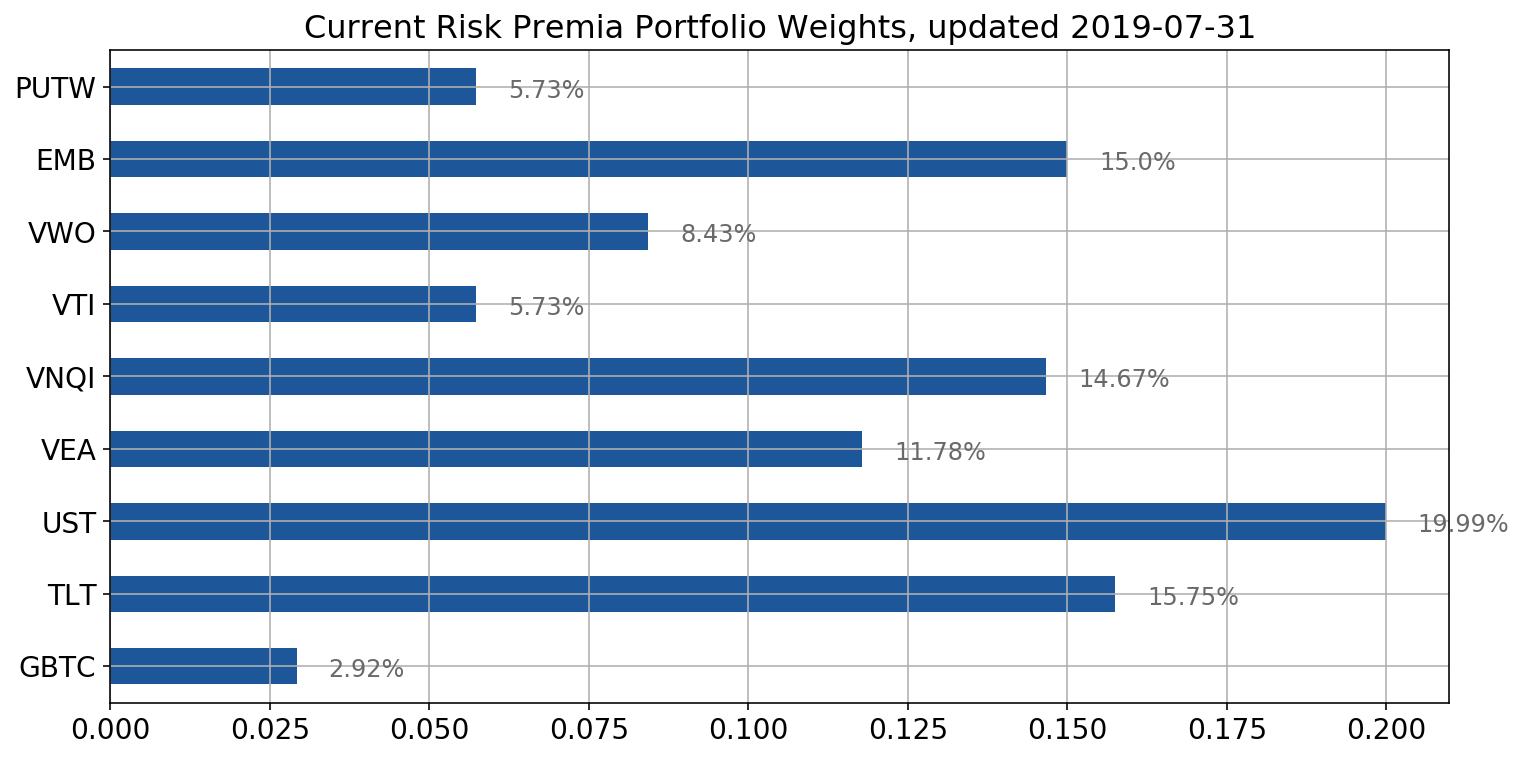

In [12]:
# plot weights
plt.rcParams["figure.figsize"] = (12, 6)
ax = final_weights.plot.barh(fontsize=14, grid=True, color='#1e5799')
for i in ax.patches:
    ax.text(i.get_width()+0.005, i.get_y()+0.1,
            str(round((i.get_width())*100, 2))+'%', fontsize=12,color='dimgrey')

now = datetime.datetime.now().strftime("%Y-%m-%d")
plt.title("Current Risk Premia Portfolio Weights, updated {}".format(now), fontsize=16);
# plt.savefig("RP-weights-{}".format(now));

## Adjust Existing Positions with Interactive Brokers

This section connects to an Interactive Brokers TWS or Gateway session, determines existing positions and submits new orders depending on the difference between the target portfolio and existing. 

#### **NOTE: THIS SECTION PLACES LIVE TRADES! USE A PAPER TRADING ACCOUNT UNTIL YOU ARE FAMILIAR WITH HOW IT WORKS**

To configure TWS:
* go to File-->Global Configuration-->API-->Settings
* Select `Enable ActiveX and Socket Clients`
* Unselect `Read-Only API`
* Take not of the `Socket Port` variable - you'll need it below when connecting

This configuraiton should end up looking like this:  

![TWS API Config](https://robotwealth.com/wp-content/uploads/2018/11/TWS_API_Configuration.png)


### Connect to TWS or Gateway

In [ ]:
# keeps notebook updated with new data
util.startLoop()

ib = IB()

ib.connect('127.0.0.1', 7496, clientId=0, timeout=10)  #socket port goes here. For connecting to Gateway use port=4002

If the connection is successful, the `ib` object is kept in sync with the current state of TWS, including positions, trades, account values and the like. 

Pretty much anything available in the TWS session is available via the `ib` object. 

### Get current positions, available capital, target positions, and position deltas
Change `fixed_capital` below if you want to set a fixed amount of capital to invest for this strategy, independent of current positions and NLV.

If `fixed_capital` is not set, the value of all open positions is used as amount to invest. If no open positions exist, the NLV is used instead. 

Change `max_capital` below if you want to limit the maximum amount of capital to allocate to this strategy.

In [ ]:
# set to true to use capital + position values to 
USE_NLV_PLUS_CASH = True

# fixed amount of capital to use for strategy; overrides positions value and NLV calculations
fixed_capital = 0
# max capital to use for strategy; value of "0" means no restriction
max_capital = 0

# current positions
pos_gen = (p for p in ib.positions() if p.contract.secType == "STK" and p.contract.symbol in tradeable_universe)
current_positions = [(p.contract.symbol, p.position) for p in pos_gen]
pos = pd.DataFrame(current_positions, columns=['symbol', 'position']).T
pos.columns = pos.loc["symbol", :]
pos = pd.DataFrame(pos.loc["position", :]).T
missing_assets = final_weights.index.difference(pos.columns)
missing_assets = [m for m in missing_assets if m in tradeable_universe]
missing_pos = pd.DataFrame(0, index = pos.index, columns = missing_assets)
pos = pd.concat([pos, missing_pos], axis = 1, sort = False)
pos = pos.sort_index(axis=1)

print("Current positions:")
print(pos)

if fixed_capital > 0:
    print("\nUsing fixed amount of ${:.2f} to invest.".format(fixed_capital))
    capital = fixed_capital
elif (pos == 0).all(axis=None):
    # calculate capital to allocate from NLV
    print("\nNo positions in desired assets found and 'fixed_capital' is 0, using NLV for capital allocation.")
    # capital available (use USD as currency since assets will be bought in USD)
    av = ib.accountValues()
    nlv = [v for v in av if (v.tag == 'NetLiquidationByCurrency' and v.currency == 'USD') ]
    er = [r for r in av if (r.tag == 'ExchangeRate' and r.currency == 'USD')]
    ib_capital = float(nlv[0].value)/float(er[0].value)
    # crypto_capital = 1000  # held elsewhere
    capital = ib_capital # + crypto_capital 
elif USE_NLV_PLUS_CASH:
    av = ib.accountValues()
    nlv = [v for v in av if (v.tag == 'NetLiquidationByCurrency' and v.currency == 'USD') ]
    er = [r for r in av if (r.tag == 'ExchangeRate' and r.currency == 'USD')]
    cash = [c for c in av if c.tag == 'CashBalance' and c.currency == 'BASE']
    capital = float(nlv[0].value)+float(cash[0].value)
else:
    # calculate capital to allocate from total value of current positions
    posValue = pos.loc["position"] * prices.tail(1).loc[:, prices.columns.intersection(pos.columns)]
    portValue = posValue.sum(axis=1)[0]
    print("\nPosition values:")
    print(posValue)
    print("\nPortfolio value:")
    print("${:.2f}".format(portValue))
    capital = portValue
    
if max_capital == 0 or capital < max_capital:
    print("\nUsing the total available amount of ${:.2f} to invest.".format(capital))
elif capital > max_capital:
    print("\nThe available capital is bigger than the amount of capital you wish to allocate to the strategy.")
    print("Reducing the amount to invest to ${:.2f}.".format(max_capital))
    capital = max_capital


# translate weights to target positions
port_cap = capital*final_weights.loc[tradeable_universe]  # capital deployed to each portfolio component
target_positions = np.round(port_cap/prices.loc[:, tradeable_universe].tail(1), 0)  # based on last known price of each instrument
print("\nTarget positions:")
print(target_positions)

# Required position deltas
deltas = target_positions.iloc[0:, :]-pos.iloc[0,:]

print("\nDeltas:")
print(deltas)

### Set position delta to zero if it is small compared to current position

In [ ]:
# if only very small changes required, don't adjust positions
tolerance = 0.01
for s in tradeable_universe:
    if pos.loc["position", s] == 0 or abs(deltas[s].values/pos.loc["position", s]) > tolerance:
        continue
    else:
        deltas[s] = 0
        
print(deltas)

### Zero GBTC delta (optional)

In the Robot Wealth portfolio, I'm zeroing the GBTC delta in order to prevent purchasing this asset. We hold our cyrpto exposure elsewhere. I'm comfortable leaving the GBTC exposure calculated here in cash (as of 19 Dec 2018, it was less than 1% of our portfolio's dollar allocation).

Comment or uncomment this section as appropriate for you. 

In [ ]:
# deltas['GBTC'] = 0
# deltas

### Check that we can achieve portfolio adjustments with available capital

* Due to rounding, it is possible that a position adjustment might exceed the buying power of the account by a small amount. 
* If that is the case, manually adjust down the position adjustments slightly. 

In [ ]:
# check we can achieve portfolio adjustments
required_buy_power = (deltas[deltas>0]*prices.tail(1)).sum(axis=1)
required_buy_power = required_buy_power[0]

av = ib.accountValues()
cash = [c.value for c in av if c.tag == 'CashBalance' and c.currency == 'BASE']
er = [r for r in av if (r.tag == 'ExchangeRate' and r.currency == 'USD')]
cash = float(cash[0])/float(er[0].value)

proceeds_from_sales = abs(deltas[deltas<0]*prices.tail(1)).sum(axis=1)
proceeds_from_sales = proceeds_from_sales[0]

print("Required buying power is ${:.2f}".format(required_buy_power))
if required_buy_power < cash:
    print("Can adjust portfolio using unallocated cash")
elif required_buy_power < cash + proceeds_from_sales:
    print("Can adjust portfolio using unallocated cash and proceeds from sales")
else:
    print("Required buying power exceeds cash and proceeds from sales by ${:.2f}. Adjust portfolio weights.".format(required_buy_power - cash - proceeds_from_sales))
            

### Prepare position deltas and contract objects 

These will be used when we place the necessary orders below. 

In [ ]:
# prepare deltas and contracts 

deltas_dict = deltas.to_dict('records')[0]
print("Deltas:")
print(deltas_dict)

# create and qualify contracts
contracts = [Stock(ticker, 'SMART', 'USD') for ticker in tradeable_universe]
for c in contracts:
    ib.qualifyContracts(c)

print("\nContracts:")
print(contracts)

### Place orders

#### **CAUTION: THE NEXT CELL PLACES LIVE ORDERS!! DO NOT RUN IF UNSURE.**

If you make a mistake, you can run the "cancel all orders" cell below. 

In [ ]:
### CAUTION: THIS CODE WILL PLACE ORDERS!! ###

algoName = 'RiskPremia'

def moc_order(side, quantity):
    return Order(action=side, totalQuantity=quantity, orderType='MOC', tif='DAY', orderRef=algoName)

# store orders and trades in case we want to track them later
trades = []
orders = []

# get list of all open trades to avoid duplication of orders
openTrades = [t for t in ib.openTrades()]

# place orders
for c in contracts:
    if deltas_dict[c.symbol] is not None and deltas_dict[c.symbol] != 0:
        side = "Buy" if deltas_dict[c.symbol] > 0 else "Sell"
        print("\n{} {} units of {}".format(side, abs(deltas_dict[c.symbol]), c.symbol))
        
        currentTrades = filter(lambda t: (t.contract.symbol == c.symbol and t.order.orderRef == algoName), openTrades)
        
        for t in currentTrades:
            ib.cancelOrder(t.order)
        
        this_order = moc_order(side, abs(deltas_dict[c.symbol]))
        orders.append(this_order)
        this_trade = ib.placeOrder(c, this_order)
        trades.append(this_trade)
        
        ib.sleep(1)
        assert this_trade in ib.trades()  # check that order was sent to IB


### Sell current IEF holdings

This is a one-off as we replace IEF with UST. Uncomment to retrieve your IEF holdings and close the position.

In [ ]:
# ief_contract = Stock('IEF', 'SMART', 'USD')
# ib.qualifyContracts(ief_contract)

In [ ]:
# pos_gen = (p for p in ib.positions() if p.contract.secType == "STK" and p.contract.symbol == "IEF")
# current_positions = [(p.contract.symbol, p.position) for p in pos_gen]
# current_ief_position = current_positions[0][1]
# print("selling {} IEF".format(current_ief_position))

In [ ]:
# this_order = moc_order('Sell', current_ief_position)
# orders.append(this_order)
# this_trade = ib.placeOrder(ief_contract, this_order)

In [ ]:
print(trades[0].log)

### This code cancels all orders - uncomment and run if a mistake was made above

In [ ]:
## cancel all orders that were created by this API client

for o in ib.openOrders():
        ib.cancelOrder(o)


### Disconnect

Finally, we close the connection to the TWS or Gateway session.

In [ ]:
ib.disconnect()